# CFAR 10 Adventure with JAX
Learning the basics of the JAX library.

Google Colab does not hace flax installed by default, so uncomment:

In [206]:
#pip install flax

# Imports

In [207]:
import jax
import jax.numpy as jnp
import numpy as np
import flax
from flax.training import train_state
import optax

import torch
from torchvision import datasets

import time
import matplotlib.pyplot as plt

# Data

In [208]:
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

In [209]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True),
    batch_size=batch_size, shuffle=True,
    collate_fn=custom_collate_fn,
    drop_last = True # because the last one might(does) have the wrong size
    )

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, download=True),
    batch_size=batch_size, shuffle=True,
    collate_fn=custom_collate_fn,
    drop_last = True
    )
nr_batches = np.floor(len(train_loader.dataset)/batch_size)
print(nr_batches, " batches")

Files already downloaded and verified
Files already downloaded and verified
390.0  batches


In [210]:
'''for imgs, sol in train_loader:
    print(imgs.shape)
    break'''
img_size = (32, 32, 3)
num_classes = 10

# Model
I have been experimenting with different versions.

In [211]:
# selfmade 

class master_model(flax.linen.Module): 
    @flax.linen.compact
    def __call__(self, x):#size: 32
        x = flax.linen.Conv(features=128, kernel_size=(3, 3))(x)
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 16
        x = flax.linen.Conv(features=256, kernel_size=(3, 3))(x)
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 8
        x = flax.linen.Conv(features=128, kernel_size=(3, 3))(x)
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 4
        x = x.reshape((x.shape[0], -1))  # flatten 
        # print(x.shape) # if not sure
        x = flax.linen.Dense(features=2024)(x)
        x = flax.linen.relu(x)
        x = flax.linen.Dense(features=512)(x)
        x = flax.linen.relu(x)
        x = flax.linen.Dense(features=256)(x)
        x = flax.linen.relu(x)
        x = flax.linen.Dense(features=10)(x)
        x = flax.linen.softmax(x)#saves some time
        return x


In [212]:
# https://arxiv.org/pdf/1202.2745v1.pdf
# I tried to recreate mcdnn because it was one of the first papers performing really well on this specific dataset
'''
class master_model(flax.linen.Module): 
    @flax.linen.compact
    def __call__(self, x):#size: 32
        x = flax.linen.Conv(features=300, kernel_size=(3, 3), padding="Valid")(x)#30
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#15

        x = flax.linen.Conv(features=300, kernel_size=(2, 2), padding="Valid")(x)#14
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 7

        x = flax.linen.Conv(features=300, kernel_size=(2, 2), padding="Valid")(x)#6
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 3

        x = flax.linen.Conv(features=300, kernel_size=(2, 2), padding="Valid")(x)#2
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="Valid")# 1
        x = x.reshape((x.shape[0], -1))  #is already down to size 1, but...
        # print(x.shape) # if not sure
        x = flax.linen.Dense(features=300)(x)
        x = flax.linen.relu(x)
        x = flax.linen.Dense(features=100)(x)
        x = flax.linen.relu(x)
        x = flax.linen.Dense(features=10)(x)
        x = flax.linen.softmax(x)
        return x
'''

'\nclass master_model(flax.linen.Module): \n    @flax.linen.compact\n    def __call__(self, x):#size: 32\n        x = flax.linen.Conv(features=300, kernel_size=(3, 3), padding="Valid")(x)#30\n        x = flax.linen.relu(x)\n        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#15\n\n        x = flax.linen.Conv(features=300, kernel_size=(2, 2), padding="Valid")(x)#14\n        x = flax.linen.relu(x)\n        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 7\n\n        x = flax.linen.Conv(features=300, kernel_size=(2, 2), padding="Valid")(x)#6\n        x = flax.linen.relu(x)\n        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 3\n\n        x = flax.linen.Conv(features=300, kernel_size=(2, 2), padding="Valid")(x)#2\n        x = flax.linen.relu(x)\n        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="Valid")# 1\n        x = x.reshape((x.shape[0], -1))  #is already down to size 1, but...\n        # 

# Loss

In [213]:

@jax.jit
def loss_fn(params, inputs, onehot_labels):
    # cross entropy
    predictions = master_model().apply({'params': params}, inputs)# you are predicting inside the loss
    #log_predictions = jnp.reshape(log_predictions, [log_predictions.shape[0],-1])

    #loss = -jnp.mean(jnp.sum(onehot_labels * jax.nn.log_softmax(log_predictions, axis=-1), axis=-1))
    #loss = -jnp.mean(jnp.sum(onehot_labels * log_predictions, axis=-1))
    loss = jnp.mean(optax.softmax_cross_entropy(predictions, onehot_labels))

    return  loss, predictions

# Utility

In [214]:
@jax.jit
def train_step(state, imgs, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=10)
    (loss, predictions), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params, imgs, labels_onehot)
    state = state.apply_gradients(grads=grads)  
    metrics = compute_metrics(predictions=predictions, loss=loss, labels=labels)
    return state, metrics

def compute_metrics(*, predictions, loss, labels):

    accuracy = jnp.mean(jnp.argmax(predictions, -1) == labels)

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

@jax.jit
def eval_step(state, imgs, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes = 10)
    loss, predictions = loss_fn(state.params, imgs, labels_onehot)
    return compute_metrics(predictions = predictions, loss = loss, labels=labels)

In [215]:
def train_one_epoch(state, dataloader, epoch):
    """Train for 1 epoch on the training set."""
    batch_metrics = []
    for _, (imgs, labels) in enumerate(dataloader):
        state, metrics = train_step(state, imgs, labels)
        
        batch_metrics.append(metrics)

    # Aggregate the metrics
    batch_metrics_np = jax.device_get(batch_metrics)  # back to CPU
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    return state, epoch_metrics_np

def evaluate_model(state, dataloader):#test set
    batch_metrics = []
    for imgs, labels in dataloader:
        metrics = eval_step(state, imgs, labels)
        batch_metrics.append(metrics)
    
    #Aggregate the metrics
    batch_metrics_np = jax.device_get(batch_metrics) 
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }
    return epoch_metrics_np

In [216]:
#init the model, optimizer etc.
def create_train_state(key, learning_rate, momentum, img_size):
    model = master_model()
    params = model.init(key, jnp.ones([1, *img_size]))['params']
    sgd_opt = optax.sgd(learning_rate, momentum)
    
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=sgd_opt)

# Train

In [217]:
# for some reason, train_state.TrainState.create can only be run once, so you need to restart the notebook if you want to rerun this cell
num_epochs = 300
lr = optax.linear_schedule(.002, .00001, transition_steps = round(num_epochs*(nr_batches)))
log_epochs = 30
momentum = .7
seed = 42

train_state = create_train_state(jax.random.PRNGKey(seed), lr, momentum, img_size)

In [218]:
test_metrics_dict = {}
start = time.time()
for epoch in range(num_epochs):
    train_state, train_metrics = train_one_epoch(train_state, train_loader, epoch)
    end = time.time()
    
    if epoch % 15 == 0:# don't print every update
        time_since_start = (end-start)/60 # in minutes
        print(f"Train epoch: {epoch+1}, loss: {train_metrics['loss']:.5f}, accuracy: {train_metrics['accuracy']:.5f}, \
        time: {time_since_start:.2f} minutes, estimated runtime: {((time_since_start)/(epoch+1)*num_epochs):.2f} minutes ({(epoch+1)/(num_epochs+1)*100:.2f}% complete).")

    if epoch % log_epochs == 0:#evaluate method
        test_metrics = evaluate_model(train_state, test_loader)
        print(f"\t\t\t\t---Test epoch: {epoch+1}, loss: {test_metrics['loss']:.5f}, accuracy: {test_metrics['accuracy']:.5f}---")

        test_metrics_dict[epoch+1] = test_metrics
# eval at the end
test_metrics = evaluate_model(train_state, test_loader)
print(f"\t\t\t\t---Test epoch: {epoch+1}, loss: {test_metrics['loss']:.5f}, accuracy: {test_metrics['accuracy']:.5f}---")
test_metrics_dict[epoch+1] = test_metrics

Train epoch: 1, loss: 2.31848, accuracy: 0.14058,         time: 0.11 minutes, estimated runtime: 34.34 minutes (0.33% complete).
				---Test epoch: 1, loss: 2.30415, accuracy: 0.15415---
Train epoch: 16, loss: 1.89610, accuracy: 0.56560,         time: 0.99 minutes, estimated runtime: 18.47 minutes (5.32% complete).
Train epoch: 31, loss: 1.74754, accuracy: 0.72055,         time: 1.78 minutes, estimated runtime: 17.23 minutes (10.30% complete).
				---Test epoch: 31, loss: 1.84264, accuracy: 0.61729---
Train epoch: 46, loss: 1.64374, accuracy: 0.82432,         time: 2.65 minutes, estimated runtime: 17.28 minutes (15.28% complete).
Train epoch: 61, loss: 1.59491, accuracy: 0.87013,         time: 3.49 minutes, estimated runtime: 17.15 minutes (20.27% complete).
				---Test epoch: 61, loss: 1.81066, accuracy: 0.65054---
Train epoch: 76, loss: 1.57335, accuracy: 0.88874,         time: 4.30 minutes, estimated runtime: 16.98 minutes (25.25% complete).
Train epoch: 91, loss: 1.56536, accuracy:

In [219]:
# sound when finished
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

# Visualisations

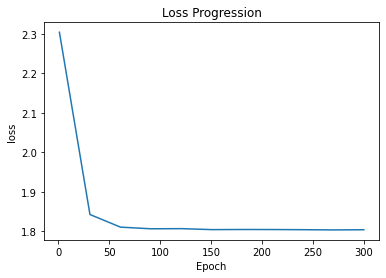

In [220]:
x = sorted(test_metrics_dict.keys())
y = [test_metrics_dict[key]["loss"] for key in x]
plt.plot(x,y)
plt.title("Loss Progression")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

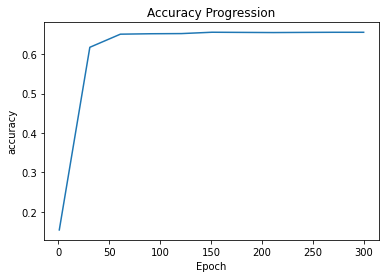

In [221]:
x = sorted(test_metrics_dict.keys())
y = [test_metrics_dict[key]["accuracy"] for key in x]
plt.plot(x,y)
plt.title("Accuracy Progression")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.show()

## Evaluation
I trained both networks for the same amount of epochs + with same learning rate (I fixed the values when working with MCDNN and then just coppied them).
MCDNN takes about 5-6 times longer to train.
Improving the training procedure would increase the performance of the models (You can see the real performance of MCDNN in the paper for refernce), but I did not have the time/GPU's to keep the models running forever.


MCDNN did not really improve a lot for the last 100 epochs, but because the accuracy is way lower than the one in the paper I assume the learning rate decayed too fast.
The final training accuracy was around 71.9% and for testing around 56.7%.

The other network got 90.4% accuracy on the raining set and 65.5% on the test set.

